In [1]:
pip install PySastrawi

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install instapy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install emoji

In [4]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import string
import emoji
import re

In [7]:
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
from scipy import stats
from string import punctuation
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import LabelEncoder
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from scipy import stats
from sklearn.linear_model import LogisticRegression
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nisha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nisha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
df = pd.read_csv('dataset_capres_fixed.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14327 entries, 0 to 14326
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  14327 non-null  int64 
 1   likesCount          14327 non-null  int64 
 2   ownerProfilePicUrl  14327 non-null  object
 3   ownerUsername       14327 non-null  object
 4   postUrl             14327 non-null  object
 5   text                14287 non-null  object
 6   timestamp           14327 non-null  object
 7   label               14327 non-null  object
dtypes: int64(2), object(6)
memory usage: 895.6+ KB


In [10]:
# Menghapus kolom yang tidak digunakan
data = df.drop(['id','ownerProfilePicUrl','postUrl', 'ownerUsername', 'timestamp', 'likesCount'], axis=1)

In [11]:
# Identifikasi dan tangani nilai-nilai yang hilang
data.isnull().sum().sort_values(ascending=False)

text     40
label     0
dtype: int64

In [12]:
# Menghapus missing value
data_cleaned = data.dropna()

In [13]:
# Menghapus duplikasi dan menyimpan dataframe yang telah dibersihkan
data_bersih = data_cleaned.drop_duplicates()
data_bersih

,text,label
0,@mhdzkypai apa yg membuat Anda bilang saya fan...,capres24
1,Busett yg korupsi naik drastis,capres24
2,"@eastindi.co ""apa yg membuat saya fanatik?"" Wk...",Anies
3,@mhdzkypai kalo saya fanatik dari dulu saya ny...,Anies
4,"@mhdzkypai gue warga Jakarta dari tahun 50, ke...",capres24
...,...,...
14321,@shint_acut nah ini..antara pendukung dan yang...,capres24
14322,@andaaruu_ herannya knp pendukungnya sampe bis...,capres24
14324,Mana like ❤️ nya no. 1 ..,capres24
14325,"@shint_acut saya heran ya, pendukung 03 , 01 k...",capres24


In [14]:
data_bersih.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13741 entries, 0 to 14326
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13741 non-null  object
 1   label   13741 non-null  object
dtypes: object(2)
memory usage: 322.1+ KB


In [15]:
# Membersihkan teks dari karakter khusus, tanda baca, angka, hashtag, mention, whitespace
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\b(\d+)([^\w\s]+)\b', '', text) # Menghapus angka yang diapit oleh karakter khusus di kedua sisinya.
    text = re.sub(r'(\d+)([^\w\s]+)', r'\1', text) # Menghapus karakter khusus yang mengikuti angka.
    text = re.sub(r'\d+', '', text)  # Menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # Menghapus karakter khusus.
    text = re.sub(r'[^\w\s\_]', '', text)  # Menghapus karakter khusus
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # Menghapus mention (diawali dengan @)
    text = re.sub(r'#([^\s]+)', '', text) # Menghapus hashtag (diawali dengan #)
    text = re.sub(r'\s+', ' ', text).strip()  # Mengganti multiple whitespace dengan satu whitespace dan menghapus leading/trailing whitespace
    text = re.sub(r'_',' ', text) # Mengganti underscore ('_') dengan whitespace.
    return text

In [16]:
# Fungsi untuk menghapus emoji dari teks
def remove_emoji(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002500-\U00002BEF"  
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [17]:
cleaned_data = data_bersih.copy()

In [18]:
cleaned_data['text'] = cleaned_data['text'].apply(clean_text)
cleaned_data['text']

0        mhdzkypai apa yg membuat anda bilang saya fana...
1                           busett yg korupsi naik drastis
2        eastindico apa yg membuat saya fanatik wkwk di...
3        mhdzkypai kalo saya fanatik dari dulu saya nyo...
4        mhdzkypai gue warga jakarta dari tahun keluarg...
                               ...                        
14321    shint acut nah iniantara pendukung dan yang di...
14322    andaaruu  herannya knp pendukungnya sampe bisa...
14324                                     mana like nya no
14325    shint acut saya heran ya pendukung kalau ngaja...
14326    shint acut ancen barbar pantes kabeh ditubruk ...
Name: text, Length: 13741, dtype: object

In [19]:
cleaned_data['text'] = cleaned_data['text'].apply(remove_emoji)
cleaned_data['text']

0        mhdzkypai apa yg membuat anda bilang saya fana...
1                           busett yg korupsi naik drastis
2        eastindico apa yg membuat saya fanatik wkwk di...
3        mhdzkypai kalo saya fanatik dari dulu saya nyo...
4        mhdzkypai gue warga jakarta dari tahun keluarg...
                               ...                        
14321    shint acut nah iniantara pendukung dan yang di...
14322    andaaruu  herannya knp pendukungnya sampe bisa...
14324                                     mana like nya no
14325    shint acut saya heran ya pendukung kalau ngaja...
14326    shint acut ancen barbar pantes kabeh ditubruk ...
Name: text, Length: 13741, dtype: object

In [20]:
cleaned_data.to_csv("dataset_capres_fix_clean.csv", index=False)

In [21]:
#casefolding
cleaned_data['text_lower'] = cleaned_data['text'].str.lower()
cleaned_data['text_lower']

0        mhdzkypai apa yg membuat anda bilang saya fana...
1                           busett yg korupsi naik drastis
2        eastindico apa yg membuat saya fanatik wkwk di...
3        mhdzkypai kalo saya fanatik dari dulu saya nyo...
4        mhdzkypai gue warga jakarta dari tahun keluarg...
                               ...                        
14321    shint acut nah iniantara pendukung dan yang di...
14322    andaaruu  herannya knp pendukungnya sampe bisa...
14324                                     mana like nya no
14325    shint acut saya heran ya pendukung kalau ngaja...
14326    shint acut ancen barbar pantes kabeh ditubruk ...
Name: text_lower, Length: 13741, dtype: object

In [22]:
#tokenizing
cleaned_data['text_tokens'] = cleaned_data['text_lower'].apply(word_tokenize)
cleaned_data['text_tokens']

0        [mhdzkypai, apa, yg, membuat, anda, bilang, sa...
1                     [busett, yg, korupsi, naik, drastis]
2        [eastindico, apa, yg, membuat, saya, fanatik, ...
3        [mhdzkypai, kalo, saya, fanatik, dari, dulu, s...
4        [mhdzkypai, gue, warga, jakarta, dari, tahun, ...
                               ...                        
14321    [shint, acut, nah, iniantara, pendukung, dan, ...
14322    [andaaruu, herannya, knp, pendukungnya, sampe,...
14324                                [mana, like, nya, no]
14325    [shint, acut, saya, heran, ya, pendukung, kala...
14326    [shint, acut, ancen, barbar, pantes, kabeh, di...
Name: text_tokens, Length: 13741, dtype: object

In [23]:
# Filter out empty strings from text_tokens:
cleaned_data['text_tokens'] = cleaned_data['text_tokens'].dropna()
cleaned_data['text_tokens'] 

0        [mhdzkypai, apa, yg, membuat, anda, bilang, sa...
1                     [busett, yg, korupsi, naik, drastis]
2        [eastindico, apa, yg, membuat, saya, fanatik, ...
3        [mhdzkypai, kalo, saya, fanatik, dari, dulu, s...
4        [mhdzkypai, gue, warga, jakarta, dari, tahun, ...
                               ...                        
14321    [shint, acut, nah, iniantara, pendukung, dan, ...
14322    [andaaruu, herannya, knp, pendukungnya, sampe,...
14324                                [mana, like, nya, no]
14325    [shint, acut, saya, heran, ya, pendukung, kala...
14326    [shint, acut, ancen, barbar, pantes, kabeh, di...
Name: text_tokens, Length: 13741, dtype: object

In [24]:
#stopwords
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()
new_stopwords = ['gw', 'gua', 'gue', 'loe', 'lo', 'lu', 'kok', 'goblok', 'guoblok','hhhh', 'haha', 'wkwkwk', 'kalo', 'hai', 'yg', 'yng', 
                 'dgn', 'dg', 'kmu', 'eh', 'gak', 'gk', 'ga', 'deh', 'hhhh', 'hah', 'gmn', 'sehh', 'bkn', 'cma', 'yo',
                 'emg', 'deh', 'pas', 'sehh', 'org', 'orng', 'bkn', 'pny', 'jmn', 'browww', 'jg', 'udh', 'alaaahhh','ha', 
                 'sklhin', 'bocil', 'bang', 'aish','ngakunya', 'biar', 'tolol', 'ngomong', 'si', 'karna', 'cie', 'emnk', 
                 'diem', 'tgl', 'ttg', 'nih', 'dmn', 'lahhh', 'dimn', 'ka', 'truss', 'up', 'aja']

data = stopwords + new_stopwords

dictionary = ArrayDictionary(data)
str = StopWordRemover(dictionary)

# Fungsi untuk menghapus stopword dari setiap token dalam kolom text_tokens
def remove_stopwords(tokens):
    return [str.remove(token) for token in tokens]

# Terapkan fungsi remove_stopwords pada setiap baris kolom text_tokens
cleaned_data['text_stopword'] = cleaned_data['text_tokens'].apply(remove_stopwords)

# Tampilkan DataFrame setelah stopword removal
cleaned_data['text_stopword'].head(50)


0     [mhdzkypai, , , , , bilang, , fanatik, , , gol...
1                        [busett, , korupsi, , drastis]
2     [eastindico, , , , , fanatik, wkwk, dibaca, , ...
3     [mhdzkypai, , , fanatik, , , , nyoblos, , , , ...
4     [mhdzkypai, , warga, jakarta, , tahun, keluarg...
5     [eastindico, caps, lock, , seakan, , , , fanat...
6     [eastindico, , , , tetangga, tetangga, , alias...
7     [mhdzkypai, pd, , , , wilayah, , pks, , junjun...
8     [mhdzkypai, , belajar, lg, bro, lulusan, , , k...
9                      [no, is, the, best, , indonesia]
10    [eastindico, pede, gimanav, , , ngajak, memban...
11    [eastindico, emang, persis, , , , diucap, pers...
12    [mhdzkypai, , , blg, tetangga, , , warga, jkt,...
13    [eastindico, the, words, ngeluh, , kinerja, an...
14    [mhdzkypai, pemberitaan, , bersumber, , buzzer...
15    [eastindico, , , follow, media, media, , netra...
16    [mhdzkypai, jd, , , percaya, media, drpd, hidu...
17                                   [berat, seb

In [25]:
#stemm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

def apply_stemming(tokens):
    return [stemmer.stem(token) for token in tokens]

# Terapkan fungsi remove_stopwords pada setiap baris kolom text_tokens
cleaned_data['text_stemm'] = cleaned_data['text_stopword'].apply(apply_stemming)

# Tampilkan DataFrame setelah stopword removal
cleaned_data['text_stemm'].head(50)

0     [mhdzkypai, , , , , bilang, , fanatik, , , gol...
1                        [busett, , korupsi, , drastis]
2     [eastindico, , , , , fanatik, wkwk, baca, , ko...
3     [mhdzkypai, , , fanatik, , , , nyoblos, , , , ...
4     [mhdzkypai, , warga, jakarta, , tahun, keluarg...
5     [eastindico, caps, lock, , akan, , , , fanatik...
6     [eastindico, , , , tetangga, tetangga, , alias...
7     [mhdzkypai, pd, , , , wilayah, , pks, , junjun...
8     [mhdzkypai, , ajar, lg, bro, lulus, , , kampus...
9                      [no, is, the, best, , indonesia]
10    [eastindico, pede, gimanav, , , ngajak, bandin...
11    [eastindico, emang, persis, , , , ucap, persis...
12    [mhdzkypai, , , blg, tetangga, , , warga, jkt,...
13    [eastindico, the, words, ngeluh, , kerja, anie...
14    [mhdzkypai, berita, , sumber, , buzzernya, , w...
15    [eastindico, , , follow, media, media, , netra...
16    [mhdzkypai, jd, , , percaya, media, drpd, hidu...
17                                     [berat, b

In [26]:
# Filter nilai kosong dari kolom 'text_stemm'
cleaned_data['text_final'] = cleaned_data['text_stemm'].apply(lambda x: list(filter(None, x)))

# Hapus array kosong dari 'text_final'
cleaned_data['text_final'] = cleaned_data['text_final'].apply(lambda x: x if x else None)

# Hapus baris dengan nilai None di kolom 'text_final'
cleaned_data.dropna(subset=['text_final'], inplace=True)

# Tampilkan 'text_final'
print(cleaned_data['text_final'])

0        [mhdzkypai, bilang, fanatik, golput, umur, tah...
1                               [busett, korupsi, drastis]
2        [eastindico, fanatik, wkwk, baca, komenan, ko,...
3        [mhdzkypai, fanatik, nyoblos, demo, luar, tp, ...
4        [mhdzkypai, warga, jakarta, tahun, keluarga, j...
                               ...                        
14321    [shint, acut, iniantara, dukung, dukung, sopan...
14322    [andaaruu, heran, knp, dukung, sampe, cinta, b...
14324                                           [like, no]
14325    [shint, acut, heran, dukung, ngajak, dapat, sa...
14326    [shint, acut, ancen, barbar, pantes, kabeh, tu...
Name: text_final, Length: 13429, dtype: object


In [27]:
cleaned_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 13429 entries, 0 to 14326
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           13429 non-null  object
 1   label          13429 non-null  object
 2   text_lower     13429 non-null  object
 3   text_tokens    13429 non-null  object
 4   text_stopword  13429 non-null  object
 5   text_stemm     13429 non-null  object
 6   text_final     13429 non-null  object
dtypes: object(7)
memory usage: 839.3+ KB


[('prabowo', 1140), ('ganjar', 1026), ('pilih', 864), ('dukung', 785), ('anies', 681)]


<Figure size 1500x600 with 0 Axes>

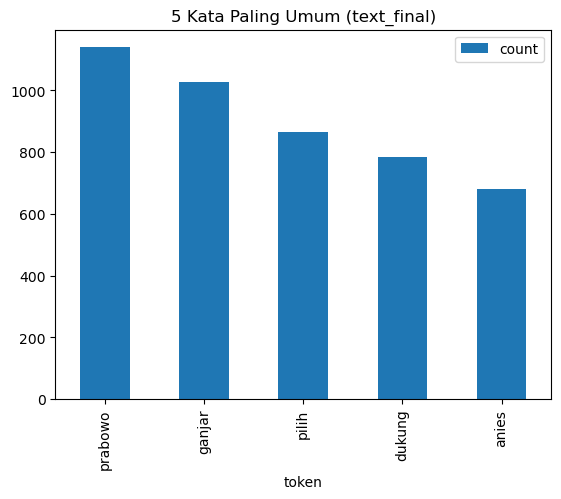

In [28]:
from collections import Counter

all_final_tokens = cleaned_data['text_final'].sum()

# Menghitung frekuensi token
final_token_counts = Counter(all_final_tokens)

# 10 kata paling umum
print(final_token_counts.most_common(5))

# Visualisasi 10 kata paling umum
final_tokens_df = pd.DataFrame(final_token_counts.most_common(5), columns=['token', 'count'])

fig = plt.figure(figsize=(15, 6))

final_tokens_df.plot(kind='bar', x='token', y='count', title='5 Kata Paling Umum (text_final)')

plt.show()


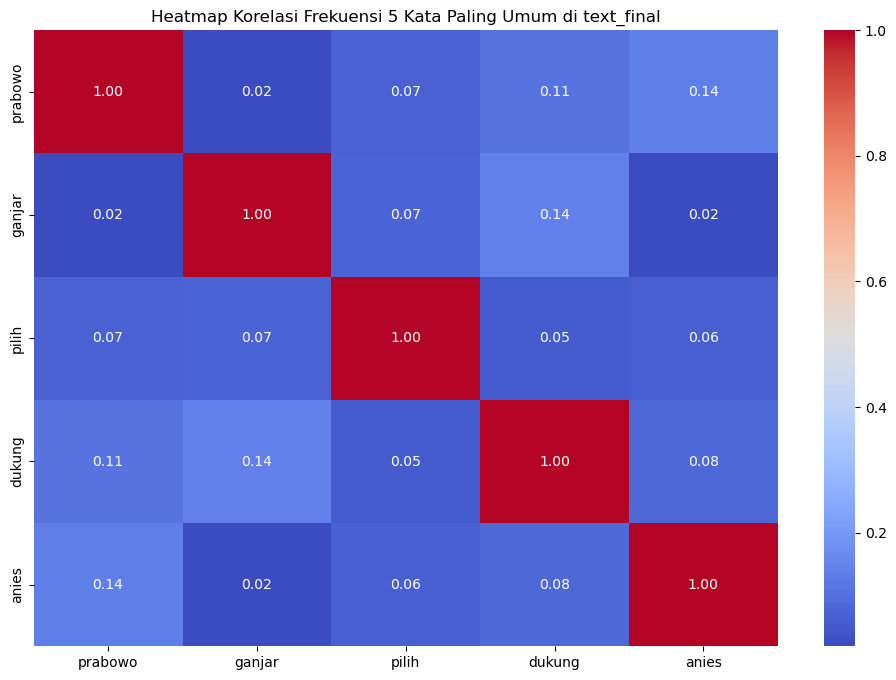

In [29]:
import seaborn as sns

# Mengambil 5 kata paling umum
common_tokens = [token for token, count in final_token_counts.most_common(5)]
token_freqs = {token: [] for token in common_tokens}

# Menghitung frekuensi token untuk 10 kata paling umum di setiap dokumen
for tokens in cleaned_data['text_final']:
    token_count = Counter(tokens)
    for token in common_tokens:
        token_freqs[token].append(token_count[token])

# Membuat DataFrame untuk heatmap
heatmap_data = pd.DataFrame(token_freqs)

# Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap Korelasi Frekuensi 5 Kata Paling Umum di text_final')
plt.show()


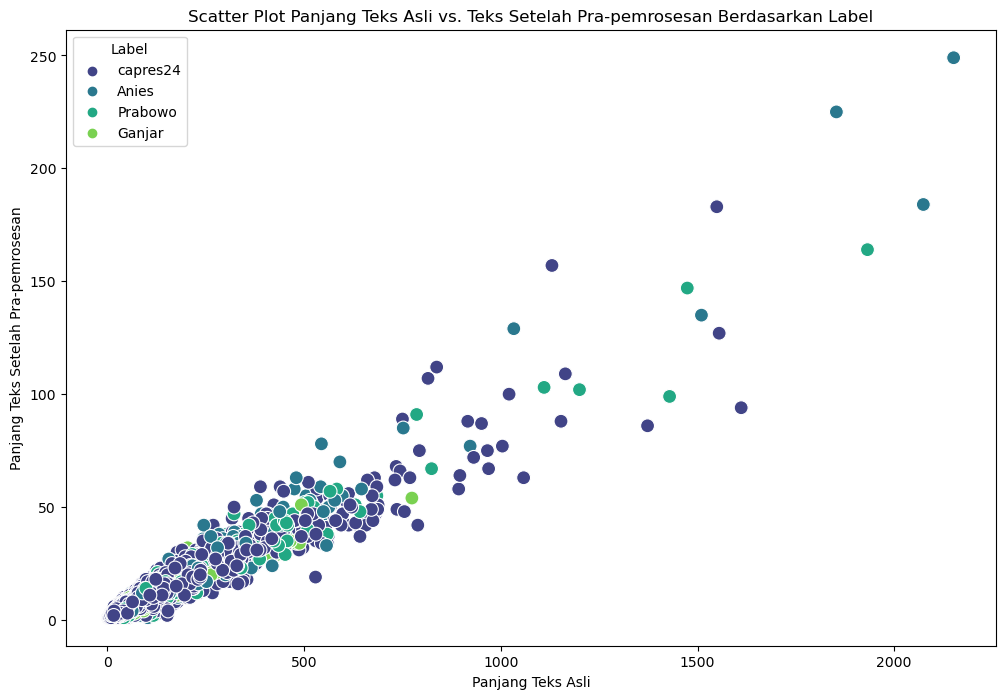

In [30]:
# Menghitung panjang teks asli dan teks setelah pra-pemrosesan
cleaned_data['text_length'] = cleaned_data['text'].apply(len)
cleaned_data['text_final_length'] = cleaned_data['text_final'].apply(len)

# Membuat scatter plot dengan seaborn, menggunakan warna berdasarkan label
plt.figure(figsize=(12, 8))
sns.scatterplot(data=cleaned_data, x='text_length', y='text_final_length', hue='label', palette='viridis', s=100)

# Menambahkan judul dan label sumbu
plt.title('Scatter Plot Panjang Teks Asli vs. Teks Setelah Pra-pemrosesan Berdasarkan Label')
plt.xlabel('Panjang Teks Asli')
plt.ylabel('Panjang Teks Setelah Pra-pemrosesan')
plt.legend(title='Label')
plt.show()

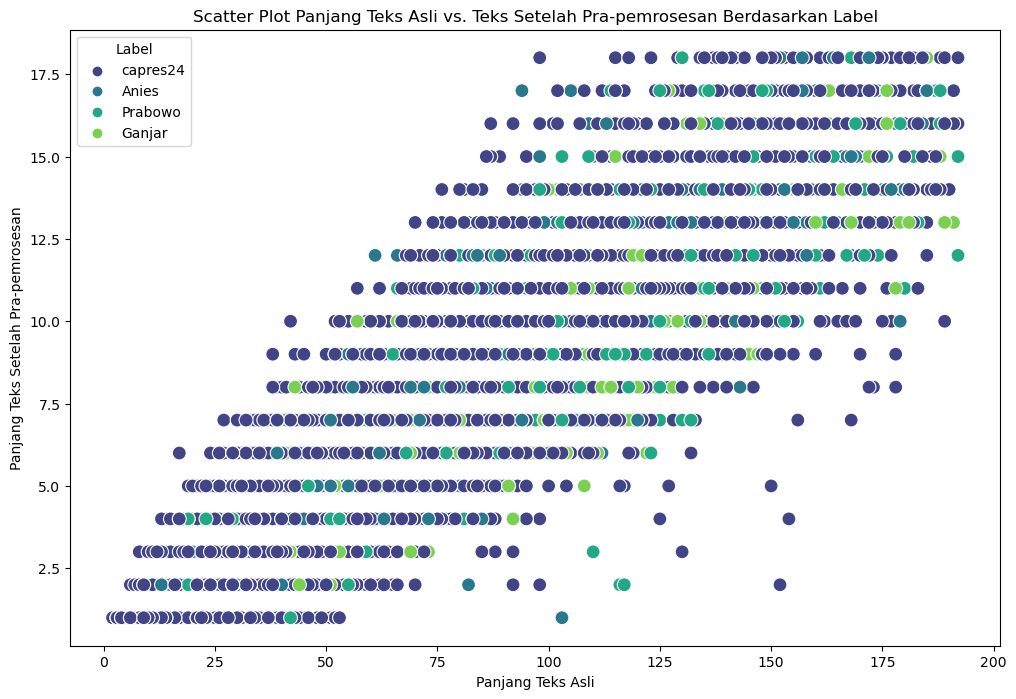

In [31]:
# Menghitung IQR untuk text_length
Q1_text_length = cleaned_data['text_length'].quantile(0.25)
Q3_text_length = cleaned_data['text_length'].quantile(0.75)
IQR_text_length = Q3_text_length - Q1_text_length

# Menghitung IQR untuk text_final_length
Q1_text_final_length = cleaned_data['text_final_length'].quantile(0.25)
Q3_text_final_length = cleaned_data['text_final_length'].quantile(0.75)
IQR_text_final_length = Q3_text_final_length - Q1_text_final_length

# Mendefinisikan batas untuk menentukan outliers
lower_bound_text_length = Q1_text_length - 1.5 * IQR_text_length
upper_bound_text_length = Q3_text_length + 1.5 * IQR_text_length

lower_bound_text_final_length = Q1_text_final_length - 1.5 * IQR_text_final_length
upper_bound_text_final_length = Q3_text_final_length + 1.5 * IQR_text_final_length

# Menghapus outliers
cleaned_data = cleaned_data[
    (cleaned_data['text_length'] >= lower_bound_text_length) & 
    (cleaned_data['text_length'] <= upper_bound_text_length) &
    (cleaned_data['text_final_length'] >= lower_bound_text_final_length) & 
    (cleaned_data['text_final_length'] <= upper_bound_text_final_length)
]

# Membuat scatter plot dengan seaborn, menggunakan warna berdasarkan label
plt.figure(figsize=(12, 8))
sns.scatterplot(data=cleaned_data, x='text_length', y='text_final_length', hue='label', palette='viridis', s=100)

# Menambahkan judul dan label sumbu
plt.title('Scatter Plot Panjang Teks Asli vs. Teks Setelah Pra-pemrosesan Berdasarkan Label')
plt.xlabel('Panjang Teks Asli')
plt.ylabel('Panjang Teks Setelah Pra-pemrosesan')
plt.legend(title='Label')
plt.show()

In [32]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12283 entries, 1 to 14326
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   text               12283 non-null  object
 1   label              12283 non-null  object
 2   text_lower         12283 non-null  object
 3   text_tokens        12283 non-null  object
 4   text_stopword      12283 non-null  object
 5   text_stemm         12283 non-null  object
 6   text_final         12283 non-null  object
 7   text_length        12283 non-null  int64 
 8   text_final_length  12283 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 959.6+ KB


In [33]:
# Gabungkan semua string dalam list 'text_final' menjadi satu string 
text_combined = [' '.join(tokens) for tokens in cleaned_data['text_final']]

# Buat objek TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, binary=True)

# Metode fit_transform pada data teks yang sudah digabungkan
tfidf_matrix = tfidf_vectorizer.fit_transform(text_combined)

# Konversi matriks TF-IDF menjadi array
tfidf_array = tfidf_matrix.toarray()

print("Ukuran TF-IDF Matrix :", tfidf_array.shape)

Ukuran TF-IDF Matrix : (12283, 1000)


In [34]:
# Dapatkan fitur dari TfidfVectorizer
terms = tfidf_vectorizer.get_feature_names_out()

# Hitung frekuensi TF-IDF dari setiap term melalui dokumen
sums = tfidf_matrix.sum(axis=0)

# Menghubungkan term dengan frekuensi jumlahnya
data = []
for col, term in enumerate(terms):
    data.append((term, sums[0, col]))

# Buat DataFrame dari data
ranking = pd.DataFrame(data, columns=['term', 'rank'])

# Urutkan DataFrame berdasarkan peringkat secara menurun
ranking = ranking.sort_values('rank', ascending=False)

print(ranking.head(20))

          term        rank
728    prabowo  321.761501
291     ganjar  295.718434
42        amin  214.258666
712      pilih  209.337708
539     mahfud  200.880625
250     dukung  198.453178
53       anies  184.690729
569     menang  178.683598
731   presiden  163.405919
368  indonesia  146.666610
307     gibran  144.873727
55        anis  135.467150
642         no  131.204472
214      debat  120.654267
749     rakyat  115.089426
744      putar  114.323626
366         in  110.870340
947       udah  108.051352
33         all  104.484202
818        sih  100.102447


In [35]:
y = cleaned_data['label']

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(tfidf_array, y_encoded, test_size=0.2, random_state=42)

# Inisialisasi model CNN
model = Sequential()

# Tambahkan layer Convolutional dan MaxPooling
model.add(Conv1D(128, 5, activation='relu', input_shape=(tfidf_array.shape[1], 1)))
model.add(MaxPooling1D(pool_size=4))
model.add(Dropout(0.2))

# Flatten layer untuk mengubah output menjadi satu dimensi
model.add(Flatten())

# Tambahkan layer Dense
model.add(Dense(10, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Ubah menjadi 4 karena ada 4 kelas

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Melatih model
model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train, validation_data=(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test), epochs=10, batch_size=64, callbacks=[EarlyStopping(patience=3)])


C:\Users\nisha\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.7791 - loss: 0.7947 - val_accuracy: 0.8873 - val_loss: 0.3336
Epoch 2/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.8982 - loss: 0.3124 - val_accuracy: 0.9613 - val_loss: 0.1868
Epoch 3/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.9638 - loss: 0.1571 - val_accuracy: 0.9674 - val_loss: 0.1246
Epoch 4/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.9731 - loss: 0.1181 - val_accuracy: 0.9731 - val_loss: 0.1186
Epoch 5/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 13s 85ms/step - accuracy: 0.9736 - loss: 0.1182 - val_accuracy: 0.9764 - val_loss: 0.0979
Epoch 6/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9790 - loss: 0.0994 - val_accuracy: 0.9801 - val_loss: 0.0941
Epoch 7/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9811 - loss: 0.0872 - val_accuracy: 0.9833 - val_loss: 0.0900
Epoch 8/10
154/154 ━━━━━━━━━━━━━━━━━━━━ 29s 142ms/step - accuracy: 0.9833 - loss: 0.0759 -

77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step


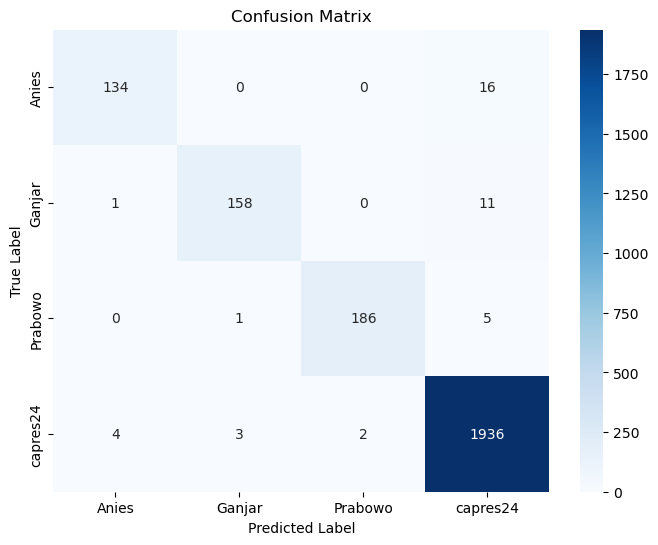

In [36]:
# Prediksi probabilitas untuk setiap kelas
y_pred_prob = model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1], 1))

# Ambil indeks kelas dengan probabilitas tertinggi
y_pred = np.argmax(y_pred_prob, axis=1)

# Matriks kebingungan (Confusion Matrix)
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualisasi matriks kebingungan menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



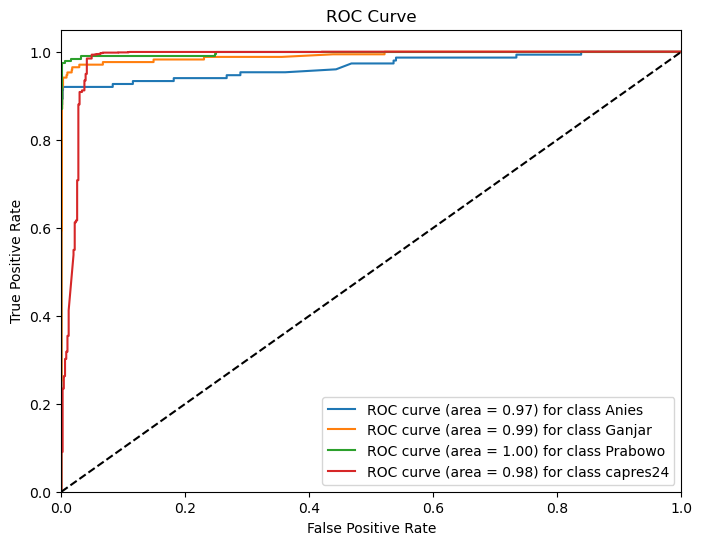

In [38]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(label_encoder.classes_)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_pred_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:0.2f}) for class {label_encoder.classes_[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()